# Evaluating Forecasts

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

# Set figure size to (14,6)
plt.rcParams['figure.figsize'] = (14,6)

# Step 1 - Load the Data

In [2]:
flights = pd.read_csv('flights_train.csv', index_col=0, parse_dates=True)
flights.head()

,passengers
date,
1949-01-01,64
1949-02-01,75
1949-03-01,98
1949-04-01,93
1949-05-01,80


In [3]:
# Inspect the size of the data
flights.shape

(132, 1)

In [ ]:
flights.describe()

In [ ]:
flights.info()

# Plot the data

In [11]:
def plot_flights(df, title='Monthly Passenger Numbers in 1000 over Time', ylim=True):
    '''
    Custom plotting function for plotting the flights dataset
    
    Parameters
    ----------
    df : pd.DataFrame
        The data to plot.
    title : str
        The title of the plot
    ylim : bool
        Whether to fix the minimum value of y; default is True
    
    Returns
    -------
    Plots the data
    '''
    df.plot()
    plt.title(title)
    plt.ylabel('# of Passengers in 1000')
    if ylim:
        plt.ylim(ymin=0)
    plt.show()

In [ ]:
plot_flights(flights)

# Step 2 - Clean the Data - this maybe 80% of your job as a DS!!

Fortunately we do not have to do that in case of the flights data.

# Step 3 - Extract the Timestep and the Seasonal Dummies for the whole Dataset

In [ ]:
# Create a timestep variable - if you had missing values or dirty data, then the below assumption wouldn't hold
#flights['timestep'] = list(range(len(flights)))
flights['timestep'] = range(len(flights))
flights.head()

### Q: Why can we use matthias suggestion of a range object instead of a list of a range object?


### A: A range object is a generator
* A range object can create a list of numbers, but in its nascent state it isn't a list
* to extract a list from a range object, you need to pull the values out of it
* how do you pull values out of a range object? - you need to iterate over them

In [ ]:
iterator = iter(range(len(flights)))

In [ ]:
#we can run cell this 131 (len(flights)) times, before we hit an error
next(iterator)

In [ ]:
flights.head()

In [ ]:
# Q: why does pandas accept list(range(len(flights))) or range(len(flights)) ? 
# A: I don't exactly know, but there'll be something like the below in pandas codebase somewhere
def make_a_column(input_):
    if type(input_) == list:
        #make a column of that list
    elif type(input_) == range:
        #use a iterable on the range object, store the results in a list and proceed

In [5]:
# Create the seasonal dummies
seasonal_dummies = pd.get_dummies(flights.index.month,
                                  prefix='month',
                                  drop_first=True).set_index(flights.index)

flights = flights.join(seasonal_dummies)
flights.head()

,passengers,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
date,,,,,,,,,,,,,
1949-01-01,64,0,0,0,0,0,0,0,0,0,0,0,0
1949-02-01,75,1,1,0,0,0,0,0,0,0,0,0,0
1949-03-01,98,2,0,1,0,0,0,0,0,0,0,0,0
1949-04-01,93,3,0,0,1,0,0,0,0,0,0,0,0
1949-05-01,80,4,0,0,0,1,0,0,0,0,0,0,0


## Q: what does drop_first=True do?
### A: lets think about 3 breakfast_drinks 
* coffee
* tea
* water

In [ ]:
df1 = pd.get_dummies(['coffee', 'tea', 'water'])
df1

In [ ]:
df2 = pd.get_dummies(['coffee', 'tea', 'water'], drop_first=True)
df2.columns= ['tea', 'water_or_coffee']
df2

# 4) Train-Test-Split

Fortunately not necessary for the flights data.
* How would you train-test split a time-series? would you use train_test_split in sklearn? or some other method?
* you can't use a random splitter, we can time-series split, or you can do it manually

# 5) Model the Trend_Seasonal model

In [6]:
# Define X and y
X = flights.drop(columns=['passengers'])
y = flights['passengers']

In [7]:
# Create and fit the model
m = LinearRegression()
m.fit(X, y)

LinearRegression()

In [8]:
# Create a new column with the predictions of the trend_seasonal model
flights['trend_seasonal'] = m.predict(X)
flights.head()

,passengers,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal
date,,,,,,,,,,,,,,
1949-01-01,64,0,0,0,0,0,0,0,0,0,0,0,0,59.594697
1949-02-01,75,1,1,0,0,0,0,0,0,0,0,0,0,57.503788
1949-03-01,98,2,0,1,0,0,0,0,0,0,0,0,0,90.503788
1949-04-01,93,3,0,0,1,0,0,0,0,0,0,0,0,83.412879
1949-05-01,80,4,0,0,0,1,0,0,0,0,0,0,0,85.231061


# Plot the original data and preliminary model

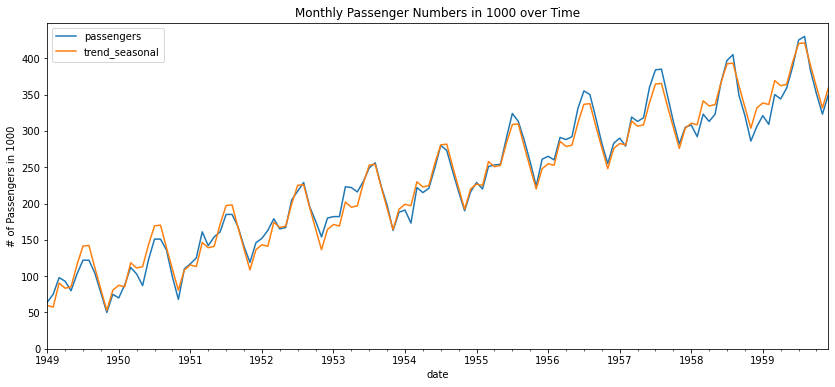

In [12]:
plot_flights(flights[['passengers', 'trend_seasonal']])

# 6) - Extract the remainder

In [ ]:
# Fast - fourier transform - which decomposes a time-series into subcomponents

In [13]:
# We want to extract the part of the model that the trend_seasonal is not able to explain
flights['remainder'] = flights['passengers'] - flights['trend_seasonal']

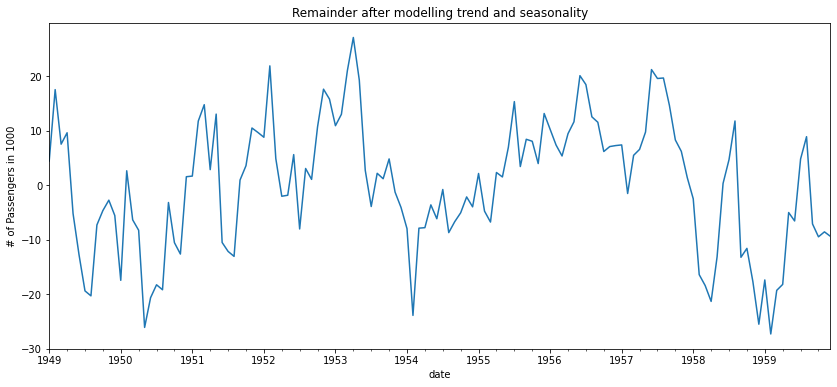

In [14]:
plot_flights(flights['remainder'], title='Remainder after modelling trend and seasonality', ylim=False)

# 7) - Inspect the remainder to decide how many lags to include

For now, I will include one lag only. - you might want to look autocorrelations to help you

# 8) - Add the lags of the remainder to the training data

In [15]:
flights['lag1'] = flights['remainder'].shift(1)
flights.dropna(inplace=True)
flights.head()

,passengers,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal,remainder,lag1
date,,,,,,,,,,,,,,,,
1949-02-01,75,1,1,0,0,0,0,0,0,0,0,0,0,57.503788,17.496212,4.405303
1949-03-01,98,2,0,1,0,0,0,0,0,0,0,0,0,90.503788,7.496212,17.496212
1949-04-01,93,3,0,0,1,0,0,0,0,0,0,0,0,83.412879,9.587121,7.496212
1949-05-01,80,4,0,0,0,1,0,0,0,0,0,0,0,85.231061,-5.231061,9.587121
1949-06-01,103,5,0,0,0,0,1,0,0,0,0,0,0,115.776515,-12.776515,-5.231061


# 9) Run the full model

In [16]:
# Assign X
X_full = flights.drop(columns=['passengers', 'trend_seasonal', 'remainder'])
y_full = flights['passengers']

In [17]:
X_full.head()

,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,lag1
date,,,,,,,,,,,,,
1949-02-01,1,1,0,0,0,0,0,0,0,0,0,0,4.405303
1949-03-01,2,0,1,0,0,0,0,0,0,0,0,0,17.496212
1949-04-01,3,0,0,1,0,0,0,0,0,0,0,0,7.496212
1949-05-01,4,0,0,0,1,0,0,0,0,0,0,0,9.587121
1949-06-01,5,0,0,0,0,1,0,0,0,0,0,0,-5.231061


In [18]:
m_full = LinearRegression()
m_full.fit(X_full, y_full)

LinearRegression()

In [19]:
# Create a new predictions column
flights['predictions_full_model'] = m_full.predict(X_full)

# 10) - Plot the prediction vs passengers for the training data

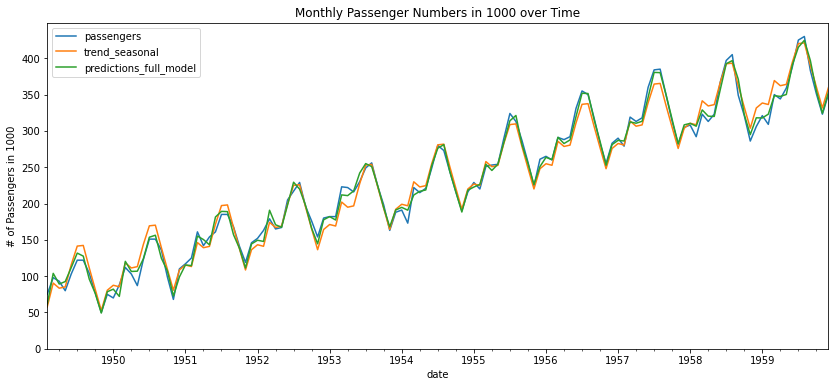

In [20]:
plot_flights(flights[['passengers', 'trend_seasonal', 'predictions_full_model']])

# Is this model good?

# 10) - Evaluate our model

We want to understand how good our model would work on data it has not been trained on. We can get an estimate of that by using cross-validation.

Cross-validation so far:

- Dividing training data into subsets (folds)
- in each iteration singled out one fold as validation set
- trained on the remaining training data and evaluated the fit on the validation set.

Cross-validation for time series:

- Dividing training data into subsets (folds)
- in the first iteration, use the first fold to evaluate the second fold
- in the second iteration, use the first and the second fold to evaluate the third fold
- ...

In [21]:
# Create a TimeSeriesSplit object
ts_split = TimeSeriesSplit(n_splits=5)

In [23]:
ts_split.split(X_full, y_full)

<generator object TimeSeriesSplit.split at 0x7fd1c291e7b0>

In [24]:
# Split the training data into folds
for i, (train_index, validation_index) in enumerate(ts_split.split(X_full, y_full)):
    print(f'The training data for the {i+1}th iteration are the observations {train_index}')
    print(f'The validation data for the {i+1}th iteration are the observations {validation_index}')
    print()
    

The training data for the 1th iteration are the observations [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
The validation data for the 1th iteration are the observations [26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46]

The training data for the 2th iteration are the observations [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46]
The validation data for the 2th iteration are the observations [47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67]

The training data for the 3th iteration are the observations [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67]
The validation data for the 3th iteration are the observations [68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88

In [25]:
# Create the time series split
time_series_split = ts_split.split(X_full, y_full) 

<generator object TimeSeriesSplit.split at 0x7fd1c291ea50>

In [26]:
# Do the cross validation
result = cross_val_score(estimator=m_full, X=X_full, y=y_full, cv=time_series_split)
result

array([0.82727944, 0.82914029, 0.95730085, 0.9419188 , 0.92308191])

In [27]:
result.mean()

0.8957442586519804

In [ ]:
result_ordinary_cv = cross_val_score(estimator=m_full, X=X_full, y=y_full, cv=5)
result_ordinary_cv

In [ ]:
result_ordinary_cv.mean()

---

# im talking about 2 different things when i talk about metrics
* Cost function - is the fuel for gradient descent
* Score on the data - how you evaluate a fitted model

* Cost - MSE
* Score - R^2

# Evaluation Metrics

# Cost 

### 1. Mean-Squared-Error (MSE)

$\frac{1}{n} \sum (y_t - \hat{y_t}) ^2$

#### Advantages:
- Is widely implemented

#### Disadvantages:
- Strong penalty on outliers - preprocess to remove outliers (what is an outlier?)
- Unit hardly interpretable
- Not comparable across models with different units

### 2. Mean Absolute Error (MAE)

$\frac{1}{n} \sum |y_t - \hat{y}_t|$

#### Advantages:

- Error is in the unit of interest
- Does not overly value outliers

#### Disadvantages:

- Ranges from 0 to infinity
- Not comparable across models with different units

### 3. Root-Mean-Squared-Error (RMSE)

$\sqrt{\frac{1}{n} \sum (y_t - \hat{y_t}) ^2}$

#### Advantages:
- Errors in the unit of interest
- Does not overly value outliers

#### Disadvantages:
- Can only be compared between models whos errors are measured in the same unit

### 4. Mean Absolute Percent Error (MAPE)

$\frac{1}{n} \sum |\frac{y_t - \hat{y}_t}{y_t}| * 100$

#### Advantages:
- Comparable over different models

#### Disadvantages:
- Is not defined for 0 values

### 5. Root Mean Squared Log Error (RMSLE)

$\sqrt{\frac{1}{n} \sum (log(y_t + 1) - log(\hat{y_t} + 1)) ^2}$

#### Advantages:
- Captures relative error
- Penalizes underestimation stronger than overestimation

# Score

### 6. $R^2$


$1 - \frac{\sum{(y_i - \hat{y_i})^2}}{\sum{(y_i - \bar{y})^2}}$

### 7. $R_{adj}^2$


$1 - (1-R^2)\frac{n-1}{n-p-1} $

* n = no.of data points
* p = no. of features

---

In [33]:
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_error, r2_score

In [34]:
#paraphased from stackoverflow1!! - link to follow
def adj_r2(df, r2_score, y_test, y_pred):
    adj_r2 = (1 - (1 - r2_score(y_test,y_pred)) * ((df.shape[0] - 1) / 
          (df.shape[0] - df.shape[1] - 1)))
    return adj_r2

In [35]:
mses = []
maes = []
rmse = []
mape = []
rmsle = []
r2 = []
ar2 = []
for i, (train_index, validation_index) in enumerate(ts_split.split(X_full, y_full)):
    model = LinearRegression()
    model.fit(X_full.iloc[train_index], y_full.iloc[train_index])
    ypred = model.predict(X_full.iloc[validation_index])
    mses.append(mean_squared_error(y_full.iloc[validation_index], ypred))
    maes.append(mean_absolute_error(y_full.iloc[validation_index], ypred))
    rmse.append(np.sqrt(mean_squared_error(y_full.iloc[validation_index], ypred)))
    mape.append(sum(abs((y_full.iloc[validation_index] - ypred) / y_full.iloc[validation_index])) * 100 / len(y_full.iloc[validation_index]))
    rmsle.append(np.sqrt(mean_squared_log_error(y_full.iloc[validation_index], ypred)))
    r2.append(r2_score(y_full.iloc[validation_index], ypred))
    ar2.append(adj_r2(X_full,r2_score,y_full.iloc[validation_index], ypred))

In [36]:
#create a descriptive index labelling each time-series split %
index = [f'{x}%' for x in range(20,120,20)]

In [37]:
evaluations = pd.DataFrame(dict(mse=mses, mae=maes, rmse=rmse, mape=mape, rmsle=rmsle, r2=r2, adj_r2=ar2), index=index)
evaluations

,mse,mae,rmse,mape,rmsle,r2,adj_r2
20%,115.596661,8.894312,10.751589,5.286884,0.064403,0.827279,0.808088
40%,169.361106,9.659083,13.013881,4.767023,0.064155,0.829140,0.810156
60%,59.057472,6.265405,7.684886,2.373065,0.028483,0.957301,0.952557
80%,69.129536,6.404015,8.314417,2.040224,0.026455,0.941919,0.935465
100%,118.318157,8.776058,10.877415,2.545621,0.031138,0.923082,0.914535


# if you feel you need to change the cost function in your regression model, MAKE_SCORER function in sklearn to help you!!

---

# Out of scope - AIC!